In [ ]:
pip install yfinance tensorflow

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement mape (from versions: none)
ERROR: No matching distribution found for mape


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Download NIFTY 50 data (last 20 years)
nifty_data = yf.download('^NSEI', start='2005-01-31', end='2025-01-31')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Extract closing prices
data = nifty_data[['Close']]

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [6]:
#show data
data.head()

Price,Close
Ticker,^NSEI
Date,
2007-09-17,4494.649902
2007-09-18,4546.200195
2007-09-19,4732.350098
2007-09-20,4747.549805
2007-09-21,4837.549805


In [7]:
# Prepare training data
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [8]:
time_step = 60  # Using past 60 days for prediction
X, y = create_sequences(data_scaled, time_step)

In [9]:
# Split into training and testing sets
split_ratio = 0.8
split = int(len(X) * split_ratio)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [11]:
# Build LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])


c:\Users\adhik\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

In [13]:
# Define accuracy metric (Mean Absolute Percentage Error - MAPE)
def mape(y_true, y_pred_nifty):
    y_true, y_pred_nifty = np.array(y_true), np.array(y_pred_nifty)
    nonzero_idx = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred_nifty[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [14]:
# Custom callback to print loss and accuracy after each epoch
class EpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: Loss = {logs['loss']:.4f}, Val Loss = {logs['val_loss']:.4f}, MAE = {logs['mae']:.4f}, Val MAE = {logs['val_mae']:.4f}")

In [15]:
# Train the model and store training history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[EpochCallback()])

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0109 - mae: 0.0657Epoch 1: Loss = 0.0036, Val Loss = 0.0014, MAE = 0.0355, Val MAE = 0.0308
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - loss: 0.0108 - mae: 0.0654 - val_loss: 0.0014 - val_mae: 0.0308
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 6.8280e-04 - mae: 0.0183Epoch 2: Loss = 0.0007, Val Loss = 0.0035, MAE = 0.0184, Val MAE = 0.0534
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 6.8275e-04 - mae: 0.0183 - val_loss: 0.0035 - val_mae: 0.0534
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 6.5065e-04 - mae: 0.0183Epoch 3: Loss = 0.0005, Val Loss = 0.0004, MAE = 0.0165, Val MAE = 0.0169
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 6.4962e-04 - mae: 0.0182 - val_loss: 4.1465e-04 - val_mae: 0.0169
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.7314e-04 - mae: 0.0151Epoch 4: Loss = 0.0004, Val Loss = 0.0005, MAE = 0.0149, Val MAE = 0.0184
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s

In [16]:
# Predict on test data
y_pred_nifty = model.predict(X_test)
y_pred_nifty = scaler.inverse_transform(y_pred_nifty.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


In [17]:
# Calculate accuracy using MAPE
accuracy = 100 - mape(y_test_actual, y_pred_nifty)
print(f"Final Model Accuracy: {accuracy:.2f}%")

Final Model Accuracy: 97.42%


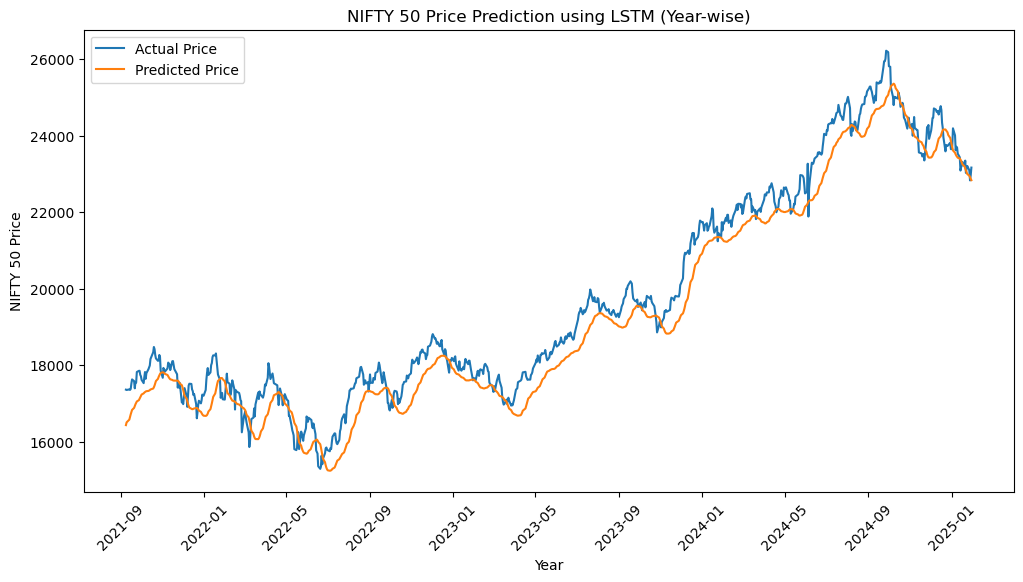

In [ ]:
# Plot results year-wise
plt.figure(figsize=(12,6))
plt.plot(nifty_data.index[split+time_step+1:], y_test_actual, label='Actual Price')
plt.plot(nifty_data.index[split+time_step+1:], y_pred_nifty, label='Predicted Price')
plt.xlabel('Year')
plt.ylabel('NIFTY 50 Price')
plt.xticks(rotation=45)
plt.legend()
plt.title('NIFTY 50 Price Prediction using LSTM (Year-wise)')
plt.show()

## **Reliance Industries** ##

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



C:\Users\adhik\AppData\Local\Temp\ipykernel_42888\1387895607.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'] = data.index.year  # Extract year from index
c:\Users\adhik\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0066 - mae: 0.0458Epoch 1: Loss = 0.0022, Val Loss = 0.0016, MAE = 0.0254, Val MAE = 0.0317
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - loss: 0.0066 - mae: 0.0456 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 4.9257e-04 - mae: 0.0141Epoch 2: Loss = 0.0005, Val Loss = 0.0010, MAE = 0.0138, Val MAE = 0.0252
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 4.9253e-04 - mae: 0.0141 - val_loss: 9.6175e-04 - val_mae: 0.0252
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 4.5303e-04 - mae: 0.0133Epoch 3: Loss = 0.0005, Val Loss = 0.0083, MAE = 0.0137, Val MAE = 0.0837
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 4.5325e-04 - mae: 0.0133 - val_loss: 0.0083 - val_mae: 0.0837
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 4.3864e-04 - mae: 0.0130Epoch 4: Loss = 0.0004, Val Loss = 0.0009, MAE = 0.0123, Val MAE = 0.0245
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step 

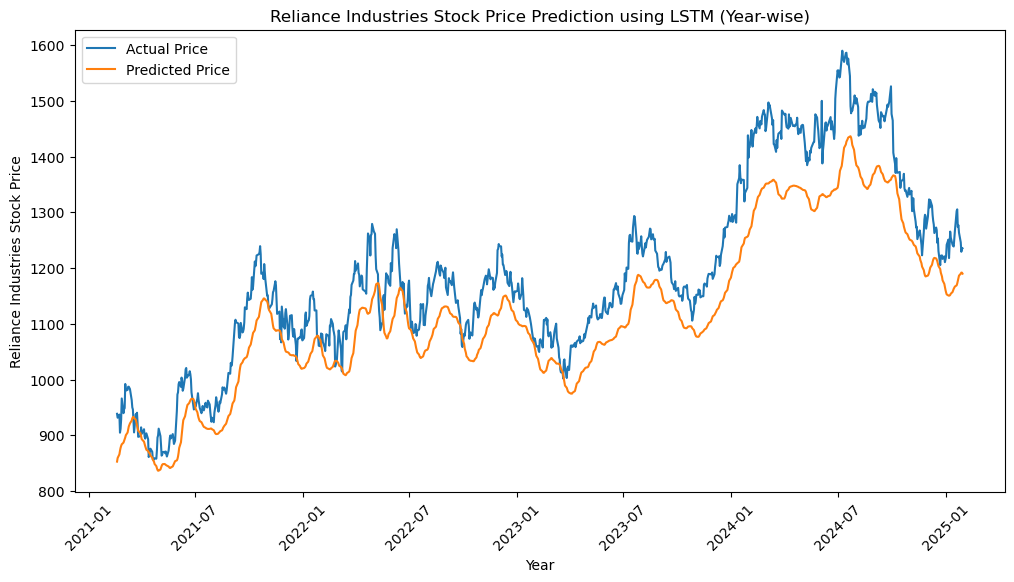

In [19]:
# Download Reliance Industries stock data (last 20 years)
reliance_data = yf.download('RELIANCE.NS', start='2005-01-31', end='2025-01-31')

# Extract closing prices
data = reliance_data[['Close']]

data['Year'] = data.index.year  # Extract year from index

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Close']])

# Prepare training data
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # Using past 60 days for prediction
X, y = create_sequences(data_scaled, time_step)

# Split into training and testing sets
split_ratio = 0.8
split = int(len(X) * split_ratio)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Define accuracy metric (Mean Absolute Percentage Error - MAPE)
def mape(y_true, y_pred_reliance):
    y_true, y_pred_reliance = np.array(y_true), np.array(y_pred_reliance)
    nonzero_idx = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred_reliance[nonzero_idx]) / y_true[nonzero_idx])) * 100

# Custom callback to print loss and accuracy after each epoch
class EpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: Loss = {logs['loss']:.4f}, Val Loss = {logs['val_loss']:.4f}, MAE = {logs['mae']:.4f}, Val MAE = {logs['val_mae']:.4f}")

# Train the model and store training history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[EpochCallback()])

# Predict on test data
y_pred_reliance = model.predict(X_test)
y_pred_reliance = scaler.inverse_transform(y_pred_reliance.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy using MAPE
accuracy = 100 - mape(y_test_actual, y_pred_reliance)
print(f"Final Model Accuracy: {accuracy:.2f}%")

# Plot results year-wise
plt.figure(figsize=(12,6))
plt.plot(reliance_data.index[split+time_step+1:], y_test_actual, label='Actual Price')
plt.plot(reliance_data.index[split+time_step+1:], y_pred_reliance, label='Predicted Price')
plt.xlabel('Year')
plt.ylabel('Reliance Industries Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.title('Reliance Industries Stock Price Prediction using LSTM (Year-wise)')
plt.show()


## Nifty 50 vs Reliance Industries (Original Price Comparison)

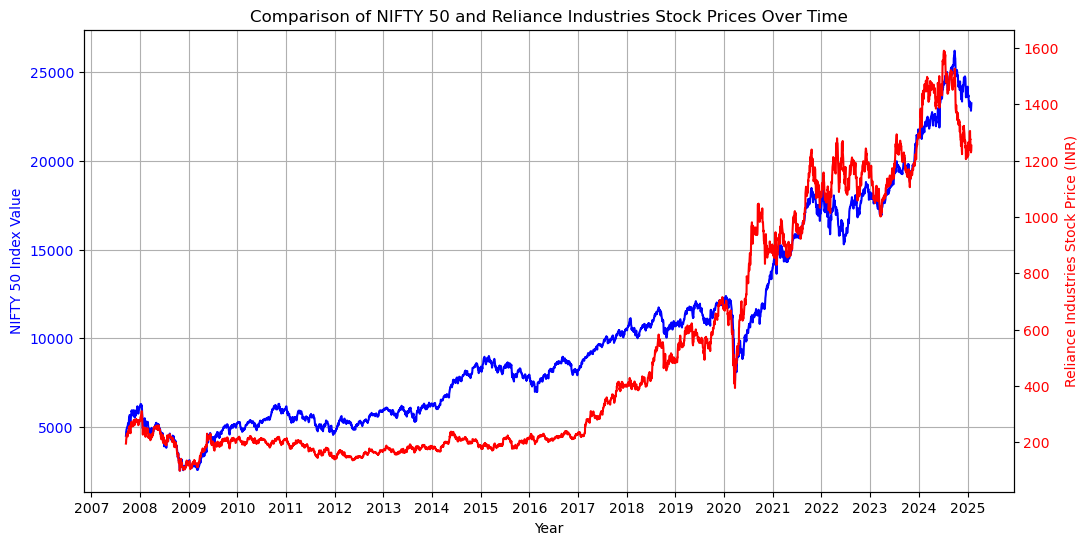

In [ ]:
import matplotlib.dates as mdates

# Ensure both datasets have the same timeframe
common_dates = nifty_data.index.intersection(reliance_data.index)
nifty_common = nifty_data.loc[common_dates]['Close']
reliance_common = reliance_data.loc[common_dates]['Close']

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot NIFTY 50 on primary y-axis
ax1.plot(common_dates, nifty_common, label='NIFTY 50 Index', color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('NIFTY 50 Index Value', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid()

# Create secondary y-axis for Reliance stock
ax2 = ax1.twinx()
ax2.plot(common_dates, reliance_common, label='Reliance Industries Stock Price', color='red')
ax2.set_ylabel('Reliance Industries Stock Price (INR)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and format x-axis
plt.title('Comparison of NIFTY 50 and Reliance Industries Stock Prices Over Time')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Show plot
plt.show()

## Nifty 50 vs Reliance Industries (Predicted Price Comparison)

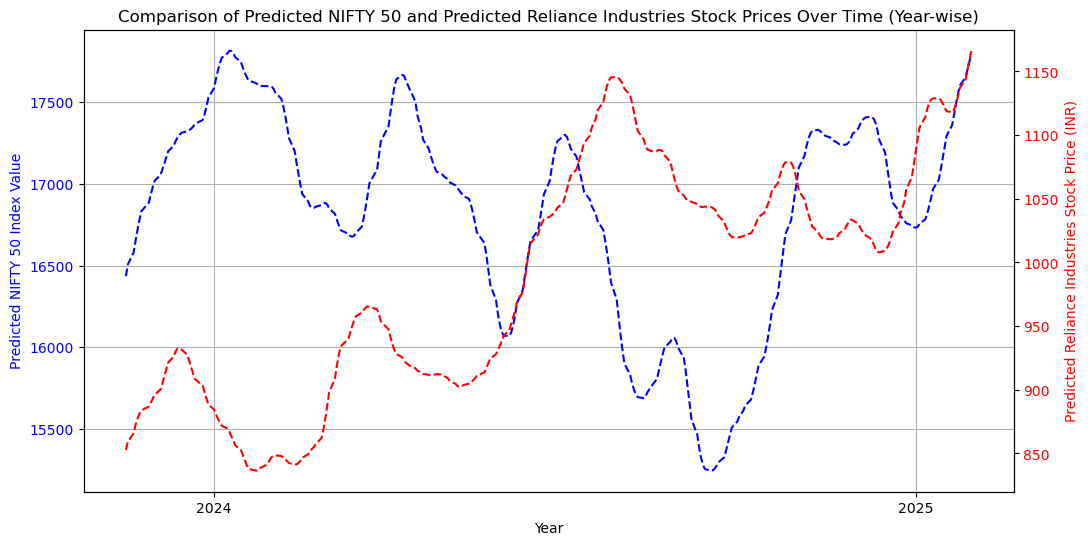

In [ ]:
# Ensure both datasets have the same timeframe
common_dates = nifty_data.index[split+time_step+1:].intersection(reliance_data.index[split+time_step+1:])
common_indices = np.where(nifty_data.index[split+time_step+1:].isin(common_dates))[0]  # Get index positions

# Extract common prediction values using indices
y_pred_nifty_common = y_pred_nifty[common_indices]
y_pred_reliance_common = y_pred_reliance[common_indices]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot predicted NIFTY 50 on primary y-axis
ax1.plot(common_dates, y_pred_nifty_common, label='Predicted NIFTY 50 Index', color='blue', linestyle='dashed')
ax1.set_xlabel('Year')
ax1.set_ylabel('Predicted NIFTY 50 Index Value', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid()

# Create secondary y-axis for predicted Reliance stock
ax2 = ax1.twinx()
ax2.plot(common_dates, y_pred_reliance_common, label='Predicted Reliance Industries Stock Price', color='red', linestyle='dashed')
ax2.set_ylabel('Predicted Reliance Industries Stock Price (INR)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and format x-axis
plt.title('Comparison of Predicted NIFTY 50 and Predicted Reliance Industries Stock Prices Over Time (Year-wise)')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Show plot
plt.show()
